In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, \
forecast_by_week, train_test_split
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, restore_HP_results, objectiveFNN, generate_model_results_by_hp_dict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from ray import tune
configuration = Configuration()

In [3]:
#experiment_path = "/home/reffert/ray_results/objectiveFNN_2023-05-27_09-47-44"
#df = restore_HP_results(experiment_path, objectiveFNN, train, test, configuration)
df1 = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/FNN_Hyperparameter_results_30_05.csv", sep=',')
df2 = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/FNN_Hyperparameter_results_30_05_02.csv", sep=',')
hp_search_space1 = {
    "num_hidden_dimensions": tune.grid_search([[40,40],[80,80],[20,20]]),
    "context_length":tune.grid_search([4, 52, 104]),
    "epochs":tune.grid_search([100, 200]),
    "prediction_length" : tune.grid_search([4]), 
    "num_batches_per_epoch":tune.grid_search([50]),
    "batch_normalization":tune.grid_search([True, False]),
    "batch_size":tune.grid_search([32]),
    }

hp_search_space2 = {
    "num_hidden_dimensions": tune.grid_search([[100,100],[80,80]]),
    "context_length":tune.grid_search([4, 52, 104]),
    "epochs":tune.grid_search([100, 200]),
    "prediction_length" : tune.grid_search([4]), 
    "num_batches_per_epoch":tune.grid_search([30, 50]),
    "batch_normalization":tune.grid_search([True, False]),
    "batch_size":tune.grid_search([32]),
    }

if "config/num_hidden_dimensions"in list(df1.columns):
    df1["config/num_hidden_dimensions"]=df1["config/num_hidden_dimensions"].apply(tuple)

if "config/num_hidden_dimensions"in list(df2.columns):
    df2["config/num_hidden_dimensions"]=df2["config/num_hidden_dimensions"].apply(tuple)
#df = df.loc[df["config/prediction_length"]==4]

In [4]:
model_results_by_hp1, overall_df1 = generate_model_results_by_hp_dict(df1, hp_search_space1)
model_results_by_hp2, overall_df2 = generate_model_results_by_hp_dict(df2, hp_search_space2)

                           total_modelruns  independent_combinations
modelruns_per_combination                                           
5.0                                    180                      36.0
                           total_modelruns  independent_combinations
modelruns_per_combination                                           
5.0                                    240                      48.0


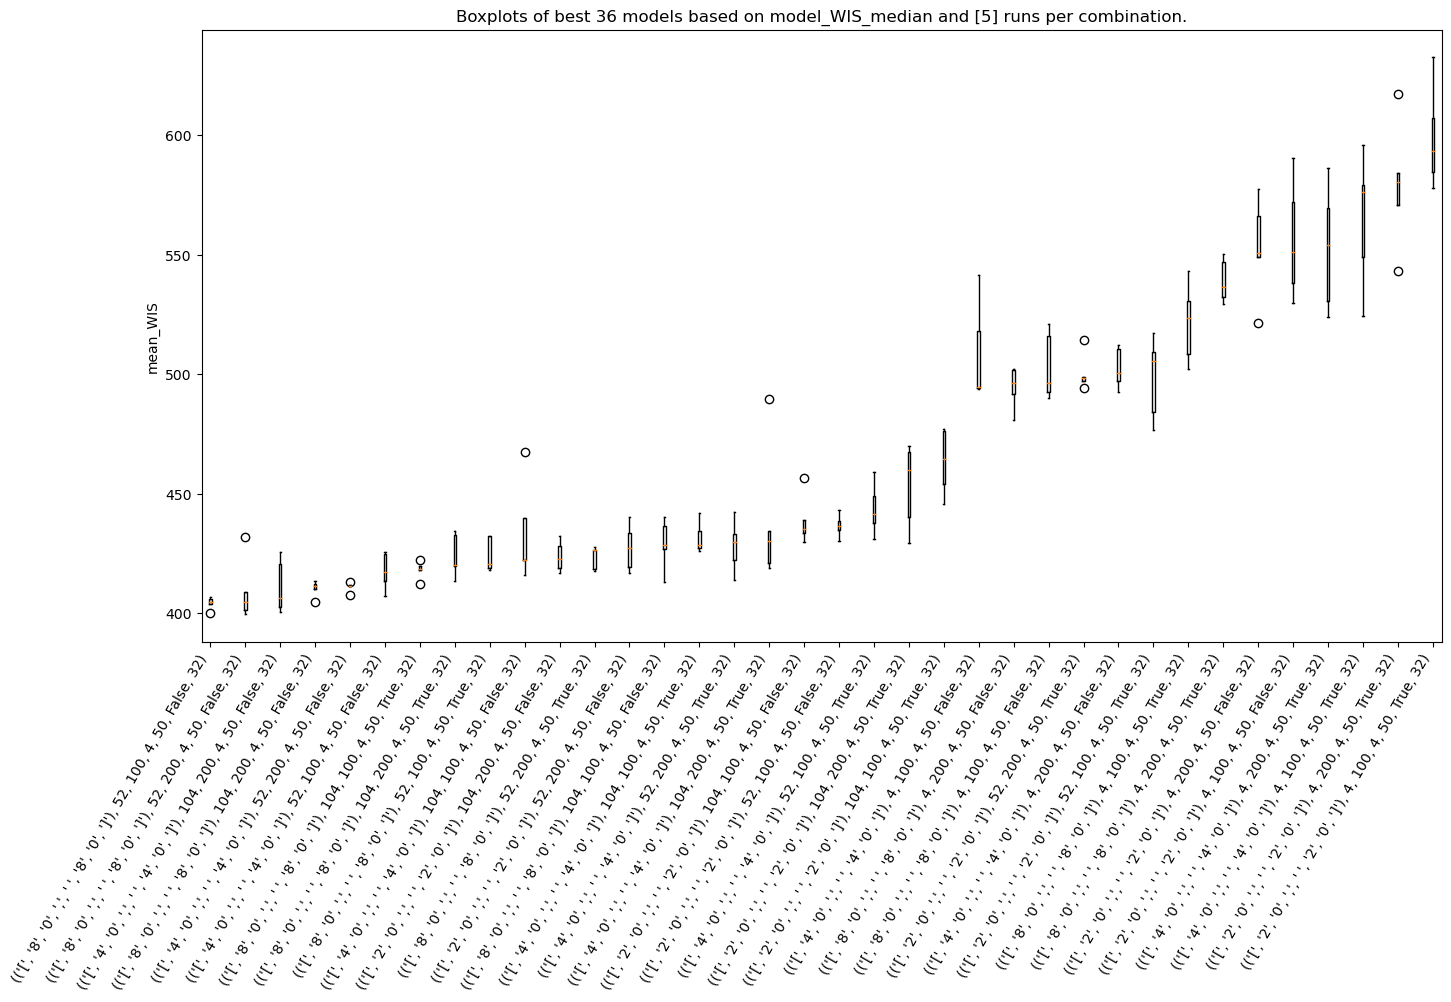

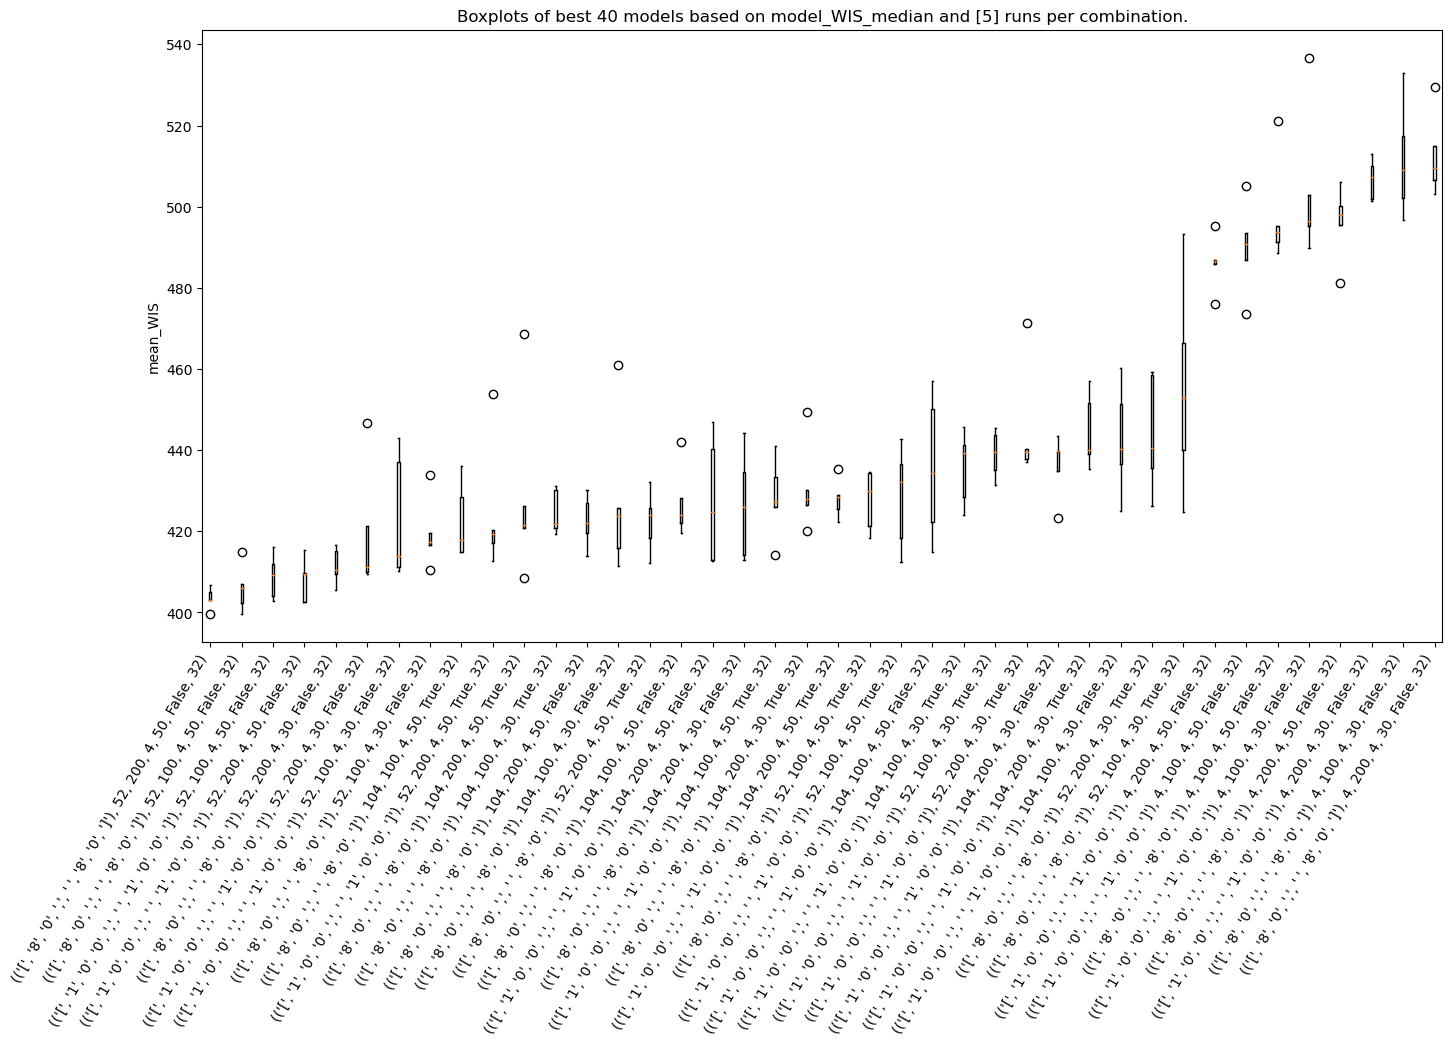

In [5]:

plot_model_results_by_hp(configuration, model_results_by_hp1, hp_search_space1, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df1, sort_by="model_WIS_median", plottype="best", plot = "bp")
plot_model_results_by_hp(configuration, model_results_by_hp2, hp_search_space2, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df2, sort_by="model_WIS_median", plottype="best", plot = "bp")

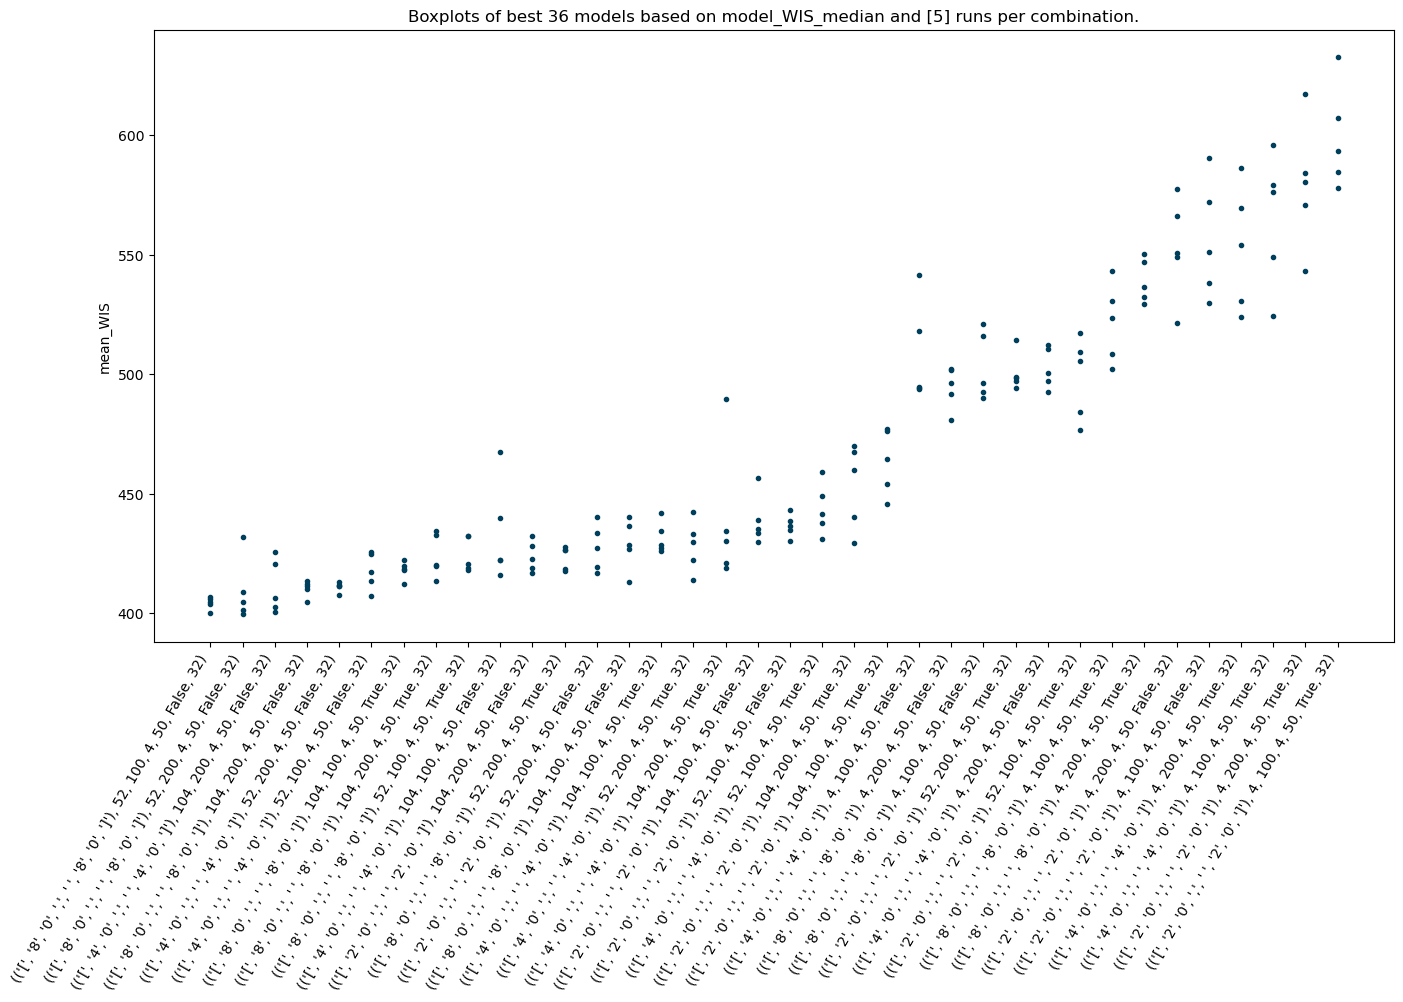

In [10]:

'''
col: "mean_WIS", "time_this_iter_s"
sort_by: "mean_WIS", "time_this_iter_s", "model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median"(, "shape") 
plottype: "unordered"(not ordered), "best" or "worst"
'''
plot_model_results_by_hp(configuration, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "scatter")

In [6]:
added_cols = ["model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median", "shape"] 
# We can't drop duplicates of num_hidden_dimensions as this column is reported as lists
display(overall_df1.sort_values("model_WIS_mean")[added_cols+[col for col in df1.columns if ("config" in col)]].drop_duplicates().head(20))
display(overall_df2.sort_values("model_WIS_mean")[added_cols+[col for col in df2.columns if ("config" in col)]].drop_duplicates().head(20))

,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_WIS_median,model_time_mean,model_time_variance,model_time_sd,model_time_median,shape,config/batch_normalization,config/batch_size,config/context_length,config/epochs,config/num_batches_per_epoch,config/num_hidden_dimensions,config/prediction_length
159,404.274504,6.581577,2.565458,404.585532,941.174707,107967.262809,328.583723,1168.548839,5.0,False,32,52,100,50,"([, 8, 0, ,, , 8, 0, ])",4
21,409.350567,172.180297,13.121749,404.878319,1817.121160,403858.397368,635.498542,2134.354753,5.0,False,32,52,200,50,"([, 8, 0, ,, , 8, 0, ])",4
131,410.393279,11.015576,3.318972,411.415524,1724.309561,327039.408586,571.873595,1927.895773,5.0,False,32,104,200,50,"([, 8, 0, ,, , 8, 0, ])",4
45,411.084625,3.935646,1.983846,411.530227,1765.399536,392442.967439,626.452686,2187.159524,5.0,False,32,52,200,50,"([, 4, 0, ,, , 4, 0, ])",4
119,411.198520,126.223706,11.234932,406.599831,1785.222644,375657.130791,612.908746,2040.612828,5.0,False,32,104,200,50,"([, 4, 0, ,, , 4, 0, ])",4
3,417.605276,60.371465,7.769908,417.151217,967.475242,94774.432856,307.854564,1020.277971,5.0,False,32,52,100,50,"([, 4, 0, ,, , 4, 0, ])",4
160,418.190107,13.119111,3.622031,418.490181,973.002576,105670.983030,325.070735,1091.965571,5.0,True,32,104,100,50,"([, 8, 0, ,, , 8, 0, ])",4
164,423.410558,23.341415,4.831295,426.467331,1825.783236,400312.812539,632.702784,2269.834886,5.0,True,32,52,200,50,"([, 8, 0, ,, , 8, 0, ])",4
35,423.752457,41.757044,6.461969,422.801681,1679.569185,356937.621515,597.442568,1622.534257,5.0,False,32,104,200,50,"([, 2, 0, ,, , 2, 0, ])",4
94,424.092550,82.127460,9.062420,420.324057,1760.102528,373274.733355,610.962137,2047.925153,5.0,True,32,104,200,50,"([, 8, 0, ,, , 8, 0, ])",4


,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_WIS_median,model_time_mean,model_time_variance,model_time_sd,model_time_median,shape,config/batch_normalization,config/batch_size,config/context_length,config/epochs,config/num_batches_per_epoch,config/num_hidden_dimensions,config/prediction_length
45,403.508400,7.180404,2.679628,403.061931,1871.714597,317481.465994,563.454937,1760.147875,5.0,False,32,52,200,50,"([, 8, 0, ,, , 8, 0, ])",4
231,405.989230,33.216222,5.763352,406.085949,1075.895517,78546.993249,280.262365,1124.821966,5.0,False,32,52,100,50,"([, 8, 0, ,, , 8, 0, ])",4
69,407.916159,28.993438,5.384556,409.413608,2043.082358,414300.370723,643.661690,2401.625739,5.0,False,32,52,200,50,"([, 1, 0, 0, ,, , 1, 0, 0, ])",4
15,408.800997,30.738643,5.544244,409.232690,1046.611119,139841.723324,373.954173,1126.136892,5.0,False,32,52,100,50,"([, 1, 0, 0, ,, , 1, 0, 0, ])",4
225,411.443444,20.257422,4.500825,410.383872,1381.679958,223202.337133,472.442946,1470.117102,5.0,False,32,52,200,30,"([, 8, 0, ,, , 8, 0, ])",4
123,419.490701,75.241792,8.674203,417.267570,756.007698,91217.427348,302.022230,939.218896,5.0,False,32,52,100,30,"([, 8, 0, ,, , 8, 0, ])",4
105,419.759811,249.590142,15.798422,411.219556,1097.002625,102439.118004,320.061116,1201.093739,5.0,False,32,52,200,30,"([, 1, 0, 0, ,, , 1, 0, 0, ])",4
140,422.415114,57.583471,7.588377,423.894052,1819.815744,232438.680829,482.118949,1879.525181,5.0,True,32,52,200,50,"([, 8, 0, ,, , 8, 0, ])",4
40,422.445241,89.665664,9.469196,417.823271,1151.224711,109571.253635,331.015489,1257.612205,5.0,True,32,104,100,50,"([, 8, 0, ,, , 8, 0, ])",4
47,422.496143,40.410400,6.356917,422.011114,1818.471077,356441.699209,597.027386,1451.493915,5.0,False,32,104,200,50,"([, 8, 0, ,, , 8, 0, ])",4


________________


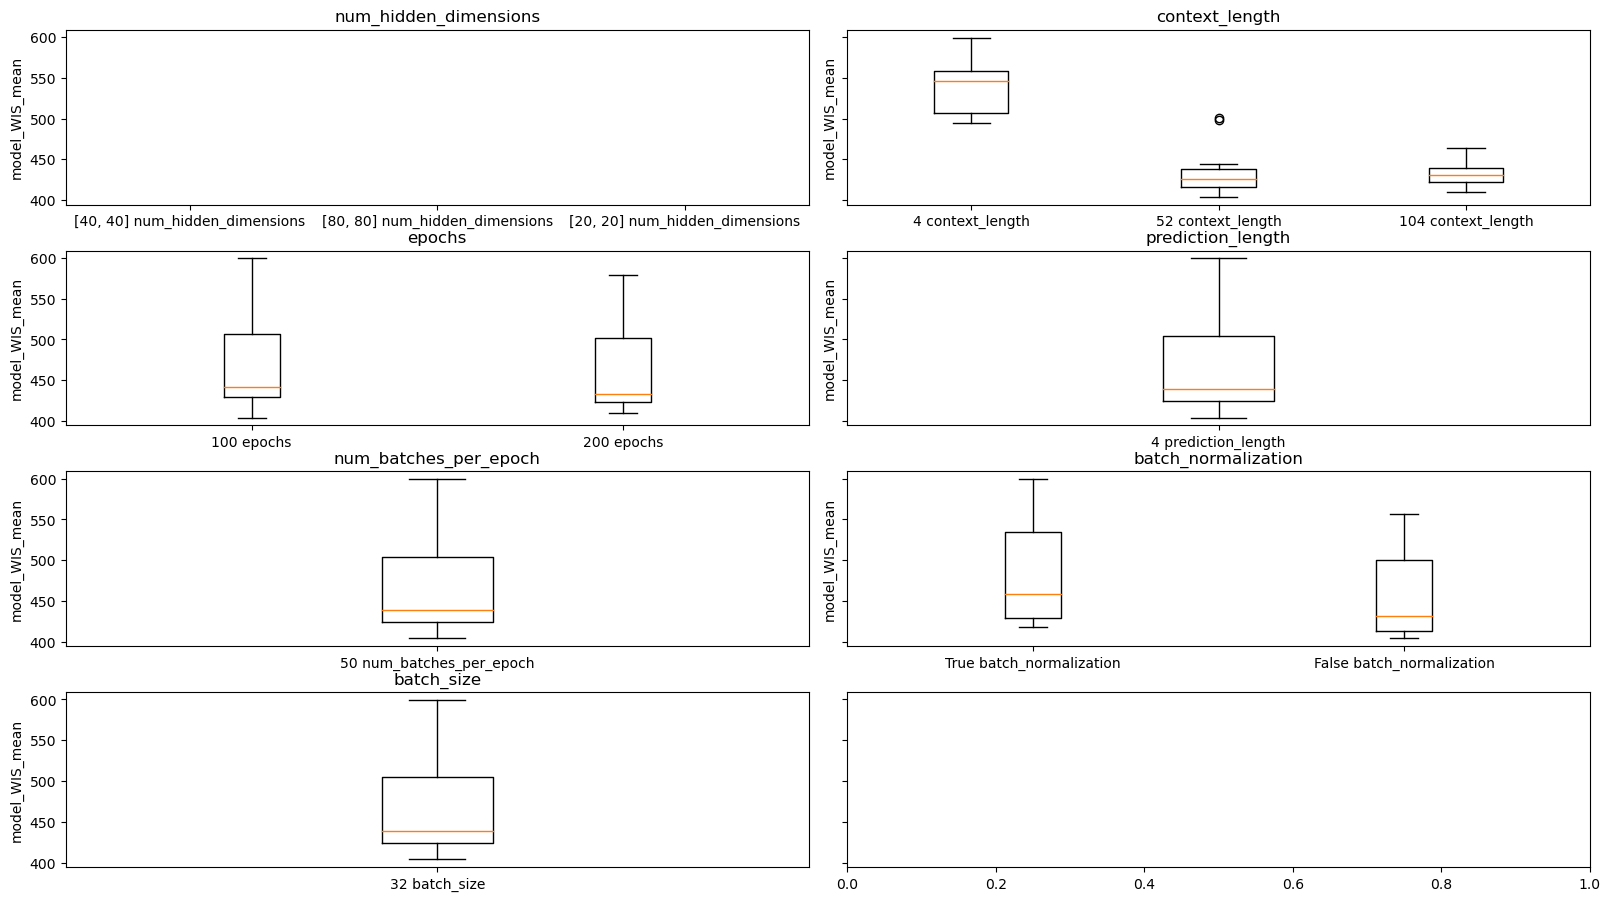

________________
________________


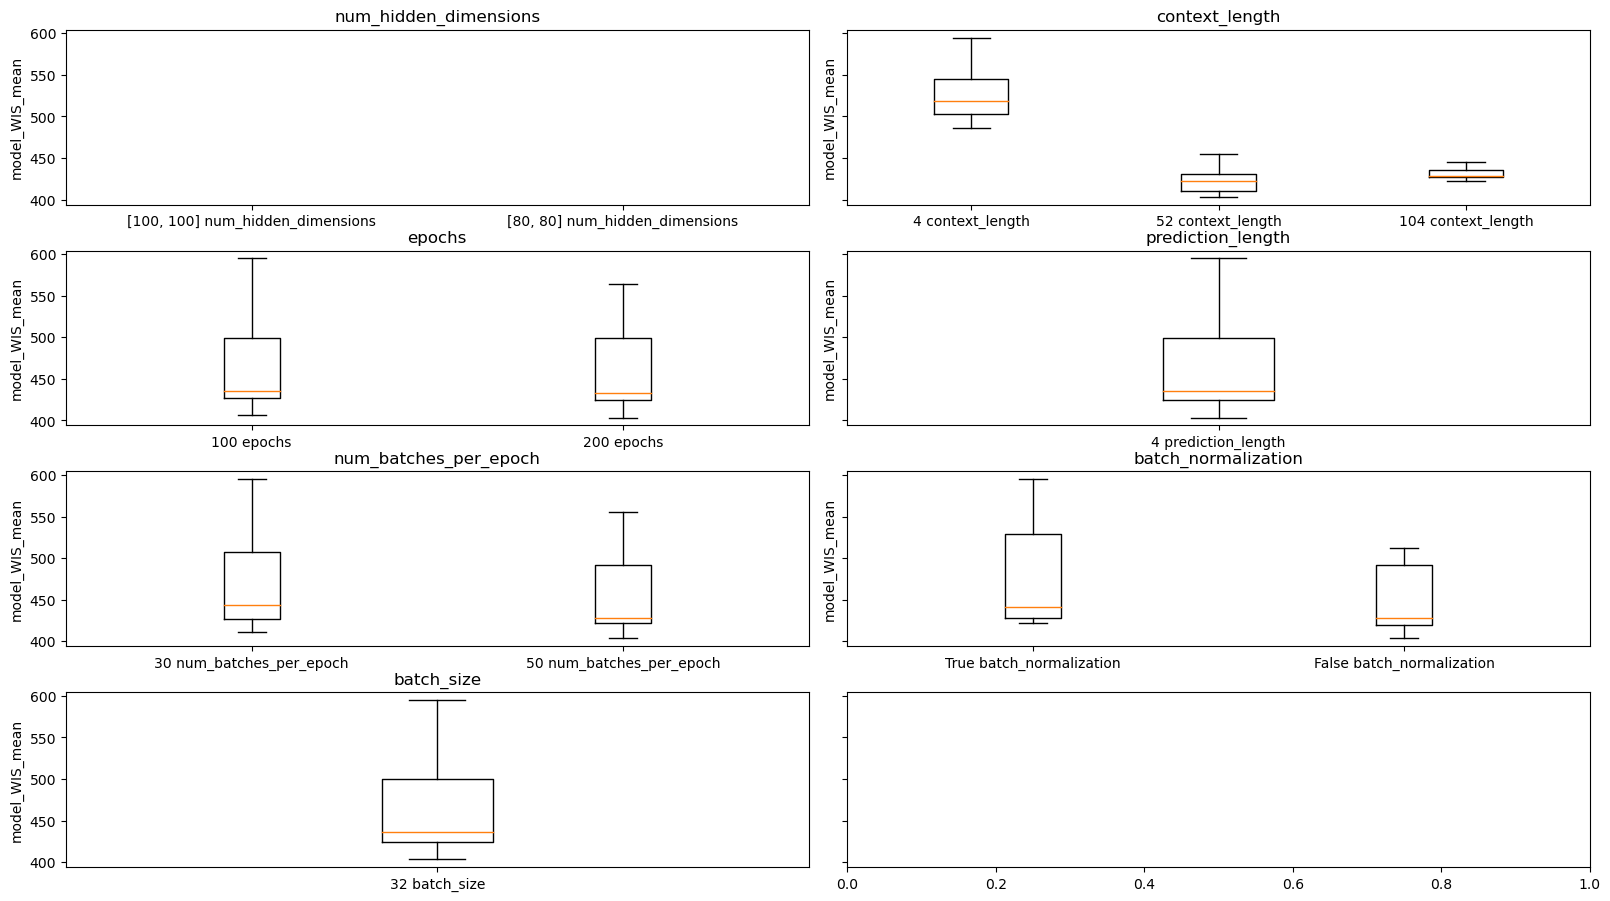

In [9]:
unique_df1 = overall_df1[added_cols+[col for col in df1.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
unique_df2 = overall_df2[added_cols+[col for col in df2.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
#hyperparameter_boxplots(unique_df1, hp_search_space1, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df1, hp_search_space1, col="model_WIS_mean")
print("________________")
#hyperparameter_boxplots(unique_df2, hp_search_space2, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df2, hp_search_space2, col="model_WIS_mean")

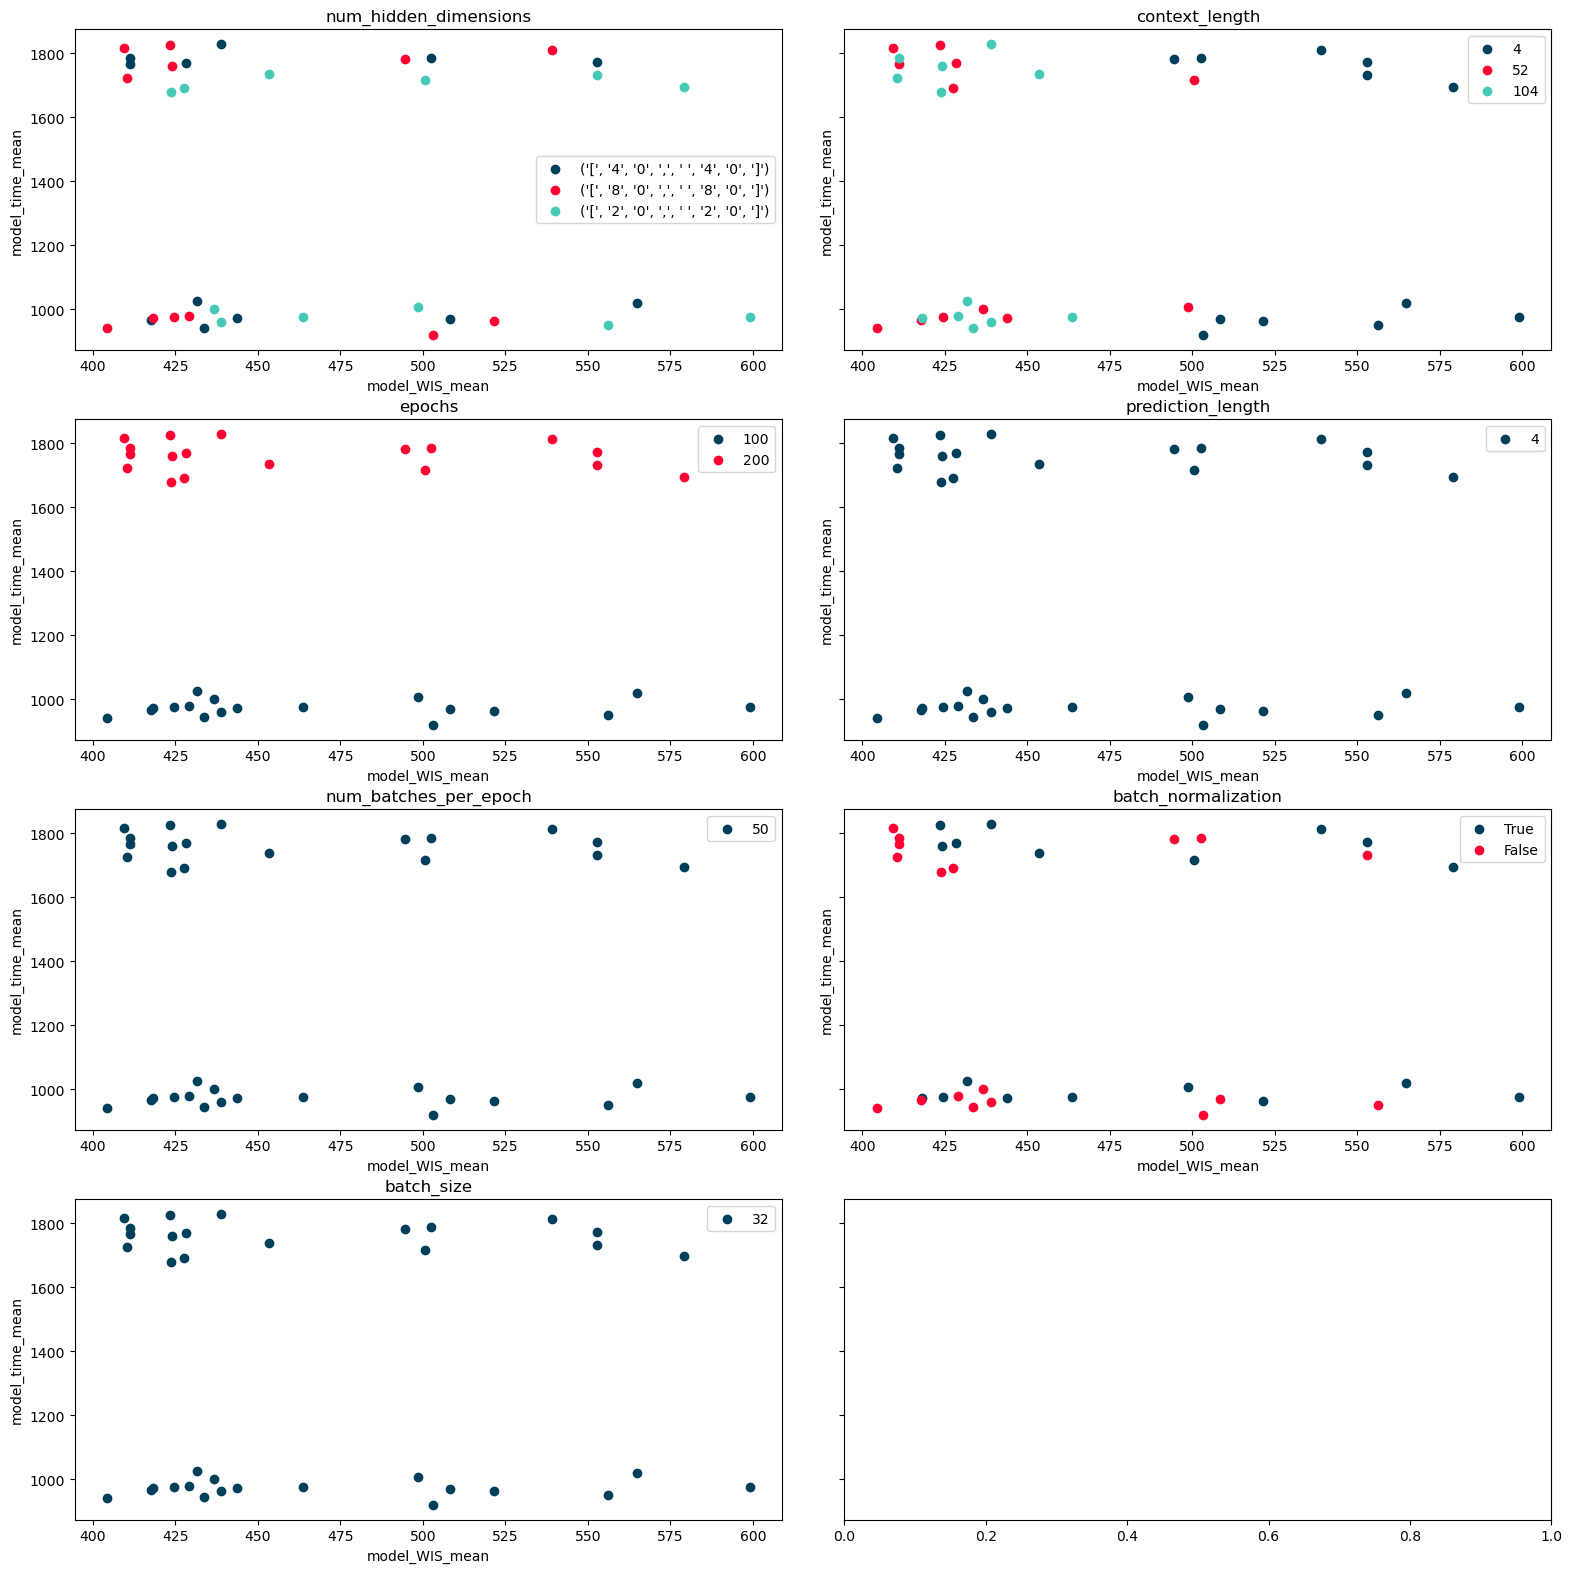

--------


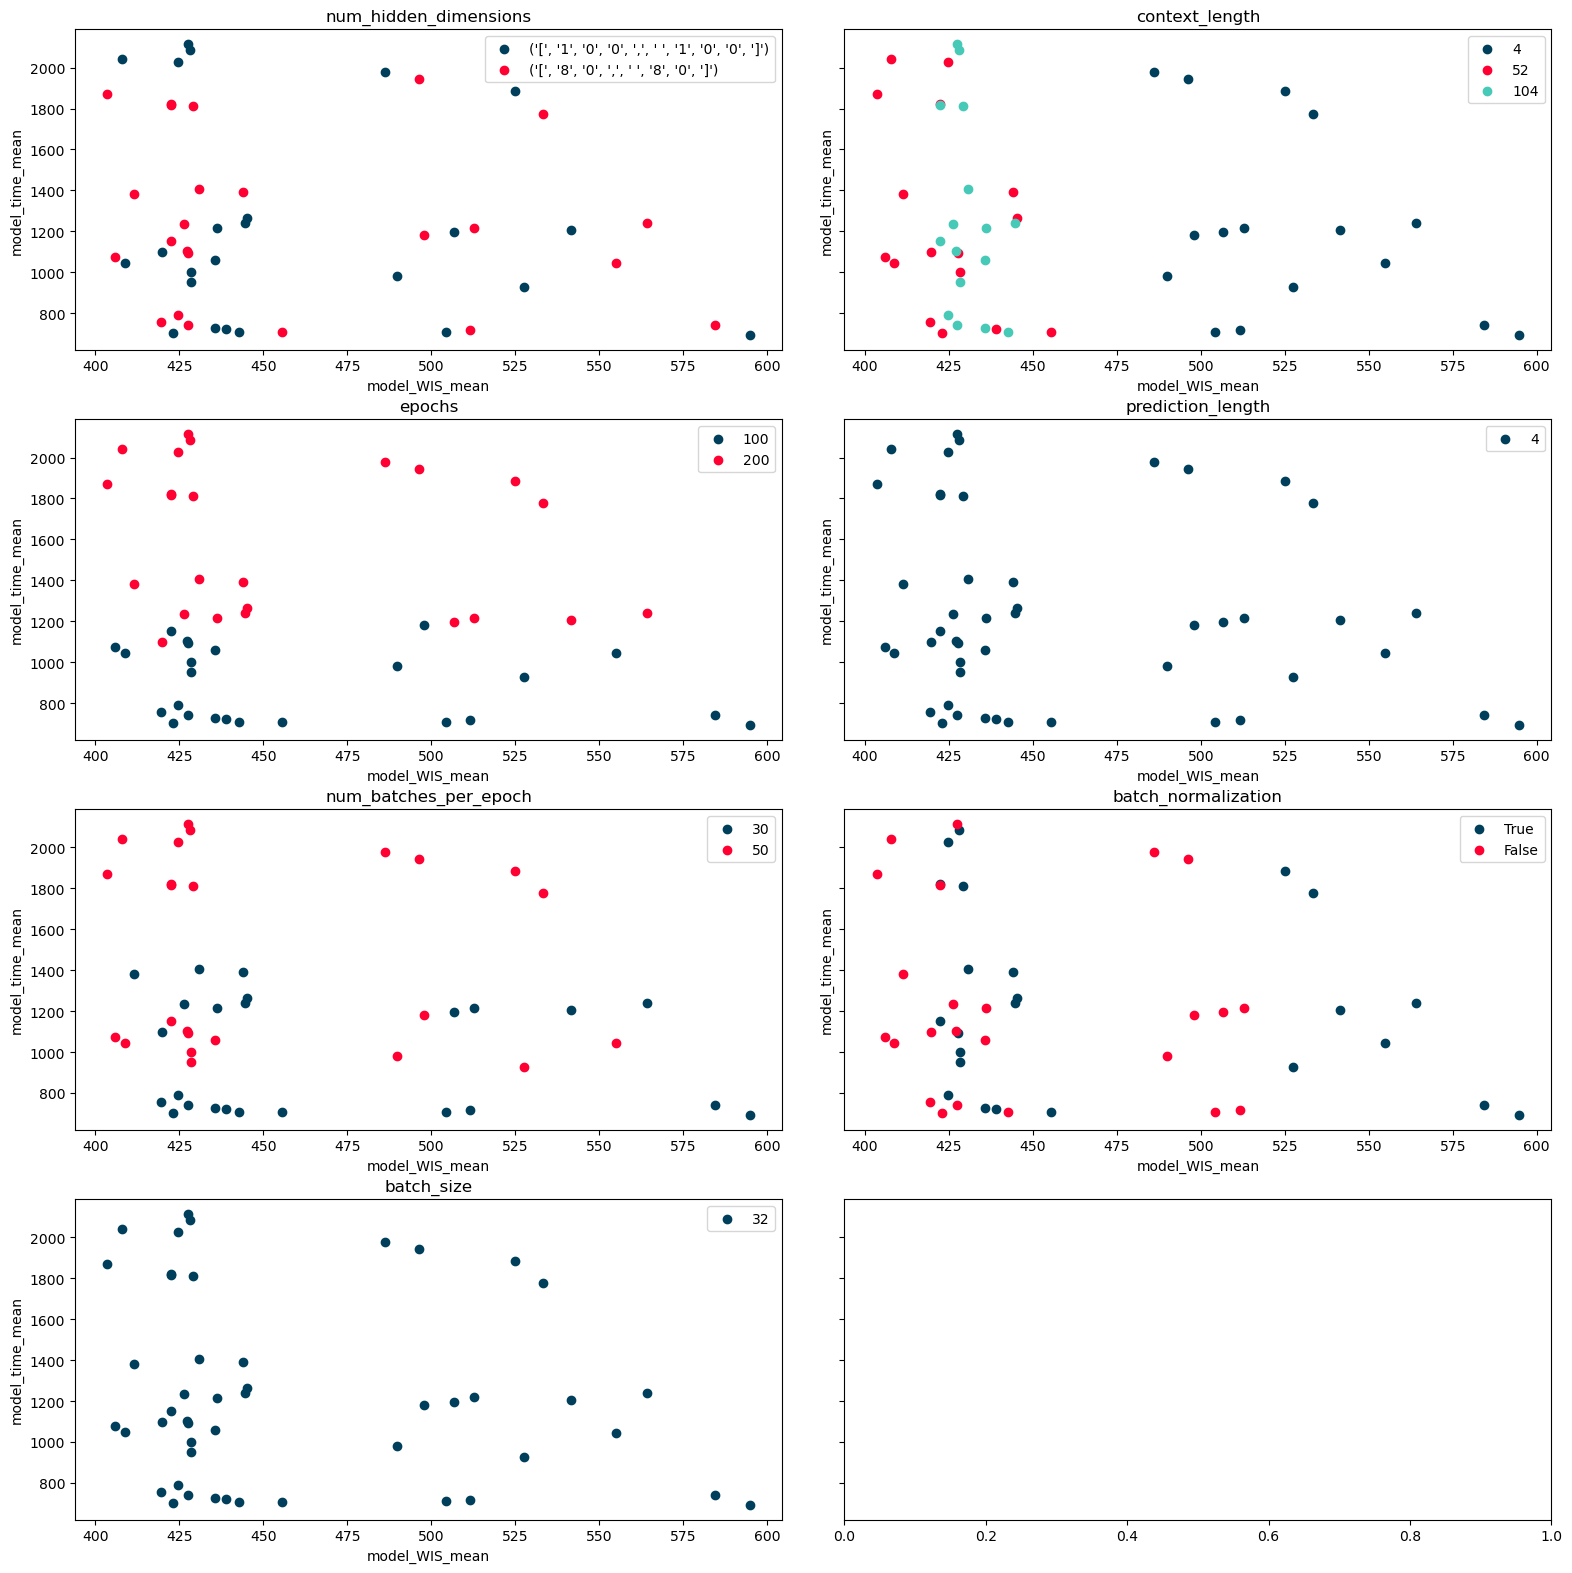

In [10]:
hp_color_plot(configuration, overall_df1, hp_search_space1, )
print("--------")
hp_color_plot(configuration, overall_df2, hp_search_space2, )

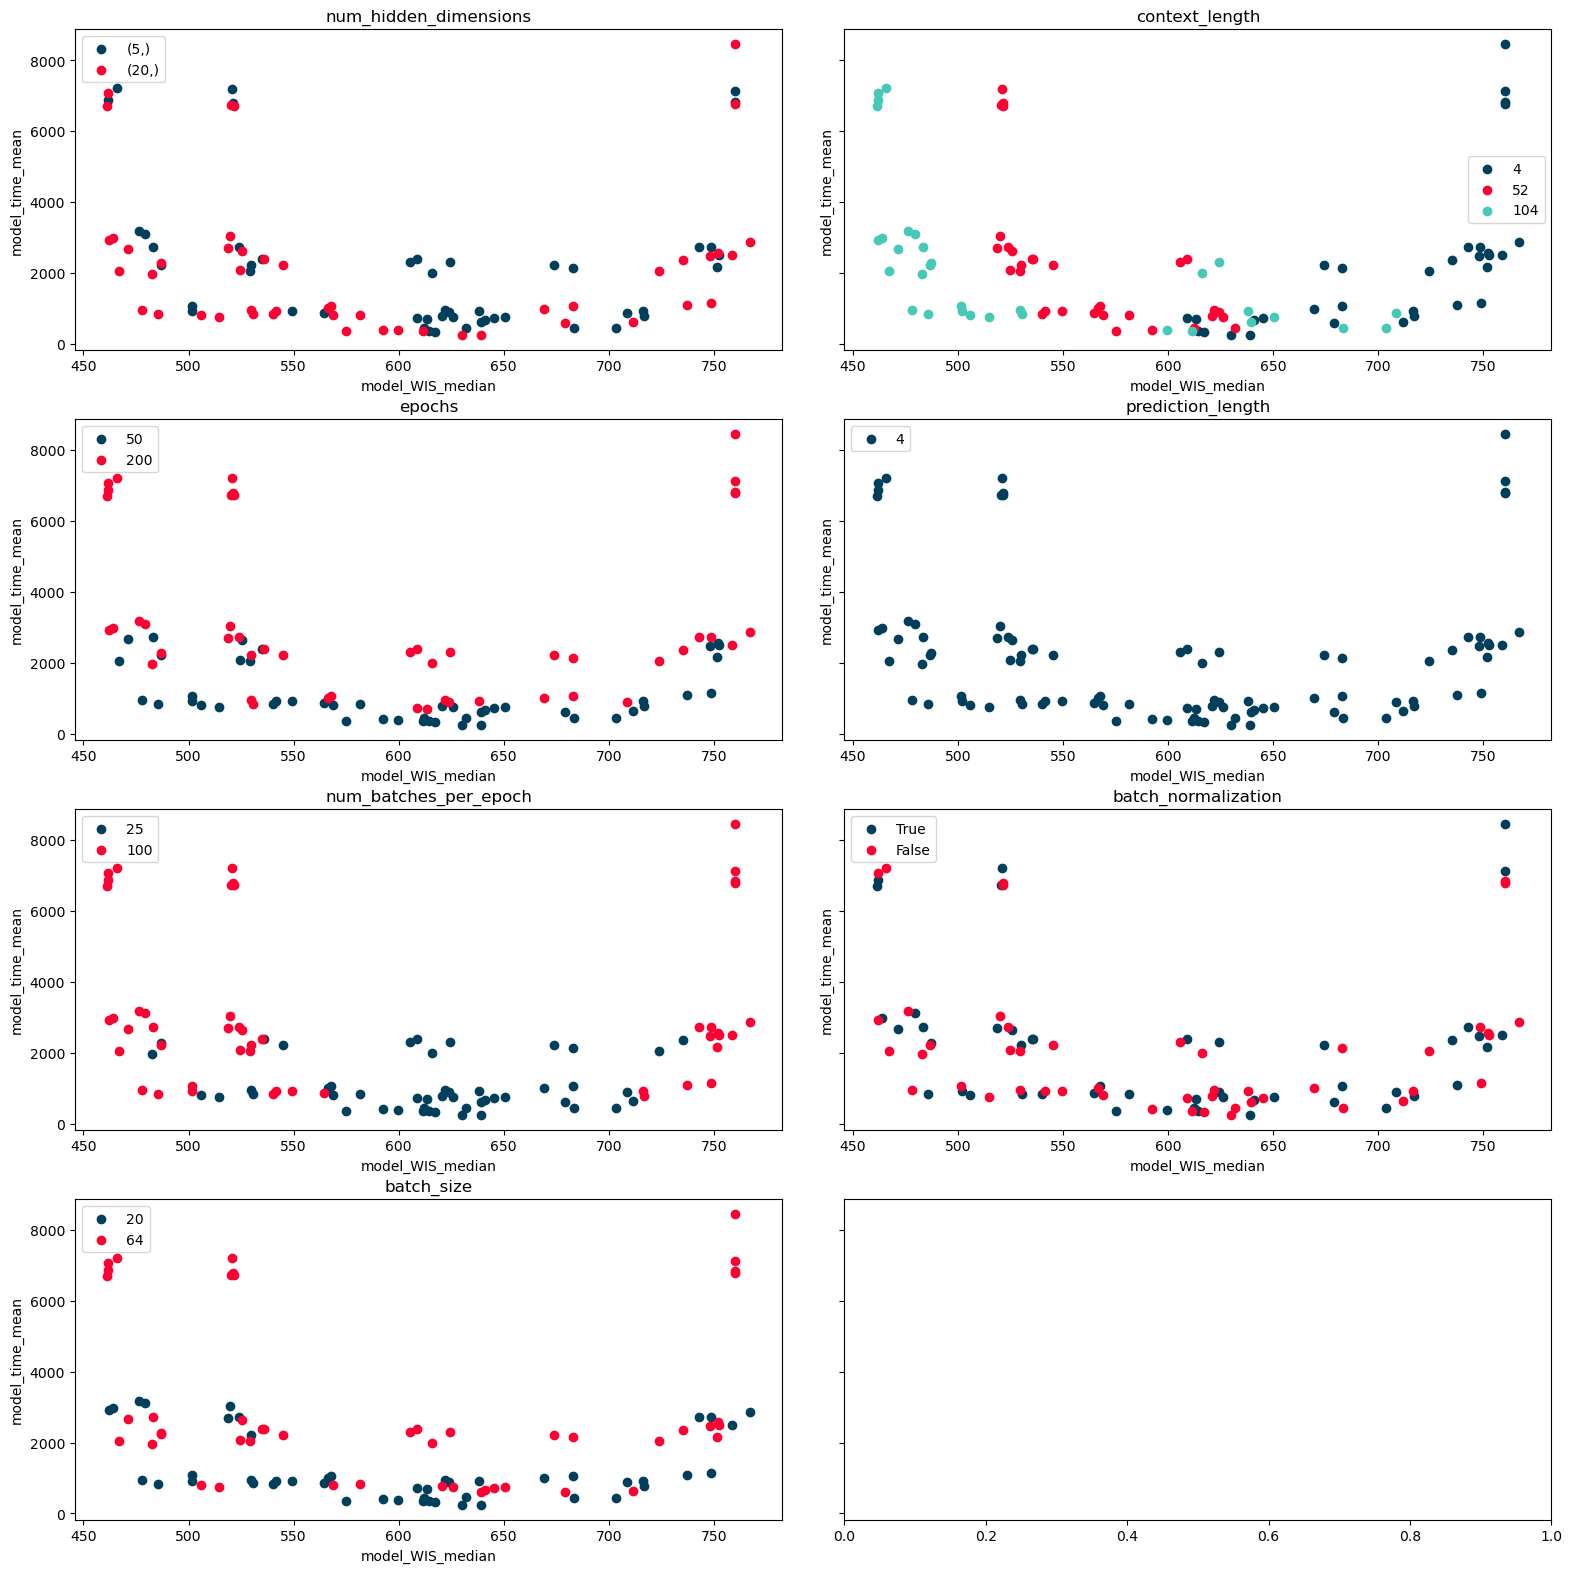

In [15]:
hp_color_plot(configuration, overall_df, hp_search_space, x_axis="model_WIS_median", y_axis="model_time_mean")